In [8]:
import os
import numpy as np
import numpy.ma as ma 
import awkward as ak
from tqdm import tqdm
import torch
import torch_geometric as tg
import torch_geometric
from torch_geometric.data import Data
#import torch
from torch_geometric.data import InMemoryDataset, download_url
import torch_geometric.transforms as T

#NOTE: NEW 2/20/23 
from typing import List, Union

from torch_geometric.data import Data, HeteroData
from torch_geometric.data.datapipes import functional_transform
from torch_geometric.transforms import BaseTransform 

torch.cuda.empty_cache()
root = '/work/clas12/users/mencke/pyg_test_rec_1500'

batch_size = 18
Lrate = 1e-3

class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Read data into huge `Data` list.
        data_list = None

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

# Create PyG Dataset
#root = '/work/clas12/users/mfmce/pyg_test_rec_traj_dataset_5_28_24/' # 3_14_24 #OLD
dataset = MyOwnDataset(
            root,
            transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
            pre_transform=None,
            pre_filter=None
        )
dataset

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.norm import GraphNorm, BatchNorm 

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
#         torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)#.jittable() #NOTE: NEEDED FOR DEPLOYMENT IN CMAKE
        self.conv2 = GCNConv(hidden_channels, hidden_channels)#.jittable()
        #self.block2 = nn.DataParallel(self.block2)
        #self.conv2 = torch.nn.DataParallel(self.conv2) #this was trying the parallization thing. 
        self.conv3 = GCNConv(hidden_channels, hidden_channels)#.jittable()
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = torch.nn.DataParallel(self.conv3)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
        self.bn1 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn2 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn3 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn4 = torch_geometric.nn.norm.GraphNorm(hidden_channels)

    def forward(self, x, edge_index, batch): 
        # 1. Obtain node embeddings 
#         print("x = ",x)
#         print("DEBUGGING: in GCN: begin: x.requires_grad = ",x.requires_grad)
        x = self.conv1(x, edge_index) #input layer
        x = self.bn1(x) #normalize it

        x = x.relu() #activation
        x = F.dropout(x, p=0.72, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)

        x = x.relu() #x = torch.sigmoid(x)
        x = F.dropout(x, p=0.72, training=self.training)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = x.relu() ########
        #x = F.dropout(x, p=0.7, training=self.training)
       # x = self.conv4(x, edge_index)
        #x = self.bn4(x)
        #x = x.relu()
        
        x = global_mean_pool(x, batch) #what is this for.           # [batch_size, hidden_channels]
        x = F.dropout(x, p=0.72, training=self.training) #for overfitting

        x = self.lin3(x)

        return x

model = GCN(dataset.num_node_features,64,2)
# model = GIN(in_channels=dataset.num_node_features,out_channels=2)
#print(model)
#print("\ndataset[0].pos = ",dataset[0].pos)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
devicee = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu') 
print("Device = ",device)
model = model.to(device)
print("DEBUGGING: torch.cuda.is_available() = ",torch.cuda.is_available())

from torch.utils.data import random_split #TODO: SEE IF YOU CAN USE THIS
# torch.manual_seed(12345)
# print('DEBUGGING: BEFORE: dataset.y.shape = ',dataset.y.shape)
dataset = dataset.shuffle() #shuffle (randmoize placement of it) not sure if this is needed. 
#print('DEBUGGING: AFTER:  dataset.y.shape = ',dataset.y.shape)

#print(len(dataset)) 

fracs = [0.8, 0.1, 0.1] #percent of dataset used for training testing and validatoin 80%,10%,10% #NOTE: SHOULD CHECK np.sum(fracs) == 1 and len(fracs)==3
fracs = [torch.sum(torch.tensor(fracs[:idx])) for idx in range(1,len(fracs)+1)] #get the indexes for training ... parts to use. 
#print(fracs)
split1, split2 = [int(len(dataset)*frac) for frac in fracs[:-1]] 
train_dataset = dataset[:split1]
val_dataset = dataset[split1:split2]
test_dataset = dataset[split2:] 

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}') 

from torch_geometric.loader import DataLoader 
#from torch.utils.data import WeightedRandomSampler


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#, drop_last=True)
val_loader = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

model = GCN(dataset.num_node_features, dataset.num_classes, 2).to(device) #initiate the model, #2 is the number of outputs here is 2 as pion_z, proton_z 

optimizer = torch.optim.Adam(model.parameters(), lr= Lrate )#1e-3) #get the optimizer

data_labels = train_dataset.y 
#weight_signal = counts[1]/counts[0]#DEBUGGING MULTIPLY BY 2 ...
#print("weight_signal = ",weight_signal) 
# weight = torch.FloatTensor([weight_signal, 1.0]).to(device) #NOTE: That labels are [sg?,bg?] so label 0 in this case is sg and label 1 is bg.
losss = torch.nn.MSELoss(reduction = 'mean').to(device)


def train():
    model.train() #initailize the model
    #for i, data in tqdm(enumerate(train_loader)): #perhaps tqdm(enumerate(train_loader)), i is index, data jsut moves through all the dtaa in trainingg
    for i,data in enumerate(train_loader):
        data = data.to(device) #switch to GPU 
        optimizer.zero_grad() #
        out = model(data.x, data.edge_index, data.batch).to(device)  # Perform a single forward pass
        yy = []
        for j in range(0,2*len(out),2): 
            fuckk = data.y[j]; fuckj = data.y[j+1]
            yy +=[[fuckk.item(),fuckj.item()]]
        yy = torch.tensor(yy).to(device)
        loss = losss(out, yy).to(device) #compute the loss
        loss.backward() #get the gradients. 
        optimizer.step() #take a step. 
        
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score 

def test(loader):
    length = len(loader.dataset)
    model.eval() #evaluate teh model.
    
    #mse_tot = []
    mse_total = 0
    mse_pi = 0
    mse_p = 0
    #r
    #for data in tqdm(loader):  # Iterate in batches over the training/test dataset.
    for data in loader:
        data = data.to(device) #put to GPU 
        out = model(data.x, data.edge_index, data.batch).to(device) #evalueate 
        #this and the for loop is converting data.y to a tensor in the same shape as out rows and 2 columns first is y_pion second is y_proton
        yy = []
        for j in range(0,2*len(out),2): 
            yy +=[[data.y[j].item(),data.y[j+1].item()]]
        yy = torch.tensor(yy).to(device)
        loss = losss(out, yy).cpu() #getting teh loss function
        mse_total+=loss.item() #getting the mse (total) 
        for j in range(len(out)): 
            #x_pi = out[j][0]; x_p =out[j][1]
            
            mse_pi += (out[j][0].item()-yy[j][0].item() )**2
            mse_p +=(out[j][1].item()-yy[j][1].item())**2
            
        #)
    return mse_total/length, np.sqrt(mse_total/length), mse_pi/length, np.sqrt(mse_pi/length), mse_p/length, np.sqrt(mse_p/length)

        
        
def print_out():
    model.eval() #initailize the model
    #for i, data in tqdm(enumerate(train_loader)): #perhaps tqdm(enumerate(train_loader)), i is index, data jsut moves through all the dtaa in trainingg
    outt= []
    for i,data in enumerate(train_loader):
        data = data.to(device) #switch to GPU 
        optimizer.zero_grad() #
        out = model(data.x, data.edge_index, data.batch).to(device)  # Perform a single forward pass
        #yy = []
        #for j in range(0,2*len(out),2):
        #    fuckk = data.y[j]; fuckj = data.y[j+1]
        #    yy +=[[fuckk.item(),fuckj.item()]]
        #yy = torch.tensor(yy).to(device)
        #loss = losss(out, yy).cpu() #compute the loss
        outt+=[out]
    return outt 
 
nepochs =  250
train_metrics = {'mse':[], "rmse":[], 'mse_pi':[], 'rmse_pi':[], 'mse_p':[], 'rmse_p':[] }
vall_metrics = {'mse':[], "rmse":[], 'mse_pi':[], 'rmse_pi':[], 'mse_p':[], 'rmse_p':[] }

for epoch in range(nepochs):
    #print("BEFORE TRAIN()") 
    train()
    #print("BEFORE TEST(TRAIN_LOADER)")
    train_mse, train_rmse, train_mse_pi, train_rmse_pi, train_mse_p, train_rmse_p = test(train_loader)
    
    train_metrics['mse'].append(train_mse)
    train_metrics['rmse'].append(train_rmse)
    train_metrics['mse_pi'].append(train_mse_pi)
    train_metrics['rmse_pi'].append(train_rmse_pi) 
    train_metrics['mse_p'].append(train_mse_p)
    train_metrics['rmse_p'].append(train_rmse_p)
    
    #print("BEFORE TEST(VAL_LOADER)")
    vall_mse, vall_rmse, vall_mse_pi, vall_rmse_pi, vall_mse_p, vall_rmse_p = test(val_loader) 
    #if epoch==0 or val_roc_auc >np.max(val_metrics["roc_auc"]) :
    #    model_best_auc = model
    #    PATH = '/work/clas12/users/mfmce/CLAS12_Lambda_resolution_REU_2023/model_best_auc.pt'
    #    torch.save({
    #        'epoch': epoch,
    #        'model_state_dict': model.state_dict(),
    #        'optimizer_state_dict': optimizer.state_dict(),
 #             'loss': loss,
    #        }, PATH) 
    
    vall_metrics['mse'].append(vall_mse)
    vall_metrics['rmse'].append(vall_rmse)
    vall_metrics['mse_pi'].append(vall_mse)
    vall_metrics['rmse_pi'].append(vall_mse)
    vall_metrics['mse_p'].append(vall_mse)
    vall_metrics['rmse_p'].append(vall_mse)  
    
    if epoch%9==0: 
        print("Epoch ",epoch," Train mse: ",train_mse," Train rmse: ",train_rmse," Train mse pion: ",train_mse_pi,
              " Train rmse pion: ",train_rmse_pi, "Train mse proton:",train_mse_p, "Train rmse proton:",train_rmse_p)
        print("Epoch ",epoch," Validation mse: ",vall_mse," Validation rmse: ",vall_rmse," Validation mse pion: ",vall_mse_pi,
              " Validation rmse pion: ",vall_rmse_pi, "Validation mse proton:",vall_mse_p, "Validation rmse proton:", vall_rmse_p) 
    if epoch==(nepochs-1): 
        a = print_out() 
        print("Epoch ",epoch," Train mse: ",train_mse," Train rmse: ",train_rmse," Train mse pion: ",train_mse_pi,
              " Train rmse pion: ",train_rmse_pi, "Train mse proton:",train_mse_p, "Train rmse proton:",train_rmse_p)
        print("Epoch ",epoch," Validation mse: ",vall_mse," Validation rmse: ",vall_rmse," Validation mse pion: ",vall_mse_pi,
              " Validation rmse pion: ",vall_rmse_pi, "Validation mse proton:",vall_mse_p, "Validation rmse proton:", vall_rmse_p) 
    if epoch>50 and vall_metrics['mse'][-1]>train_metrics['mse'][-1]:
        print("Epoch ",epoch," Train mse: ",train_mse," Train rmse: ",train_rmse," Train mse pion: ",train_mse_pi,
              " Train rmse pion: ",train_rmse_pi, "Train mse proton:",train_mse_p, "Train rmse proton:",train_rmse_p)
        print("Epoch ",epoch," Validation mse: ",vall_mse," Validation rmse: ",vall_rmse," Validation mse pion: ",vall_mse_pi,
              " Validation rmse pion: ",vall_rmse_pi, "Validation mse proton:",vall_mse_p, "Validation rmse proton:", vall_rmse_p) 
        print('break')
        break

Device =  cuda:0
DEBUGGING: torch.cuda.is_available() =  True
Number of training graphs: 1081
Number of validation graphs: 135
Number of test graphs: 136
Epoch  0  Train mse:  0.3946710915393459  Train rmse:  0.6282285344835475  Train mse pion:  8.334100491097601  Train rmse pion:  2.886884218512686 Train mse proton: 5.86361209574618 Train rmse proton: 2.4214896439477456
Epoch  0  Validation mse:  0.5025668585741961  Validation rmse:  0.7089195007715587  Validation mse pion:  8.995240543367117  Validation rmse pion:  2.9992066523277647 Validation mse proton: 7.710951912222729 Validation rmse proton: 2.7768600814990174
Epoch  9  Train mse:  0.3802738471454652  Train rmse:  0.6166634796592588  Train mse pion:  8.109256560279027  Train rmse pion:  2.8476756416907856 Train mse proton: 5.565294314068204 Train rmse proton: 2.359087602033507
Epoch  9  Validation mse:  0.4846392225336145  Validation rmse:  0.6961603425458927  Validation mse pion:  8.715776030101926  Validation rmse pion:  2.95

Text(0, 0.5, 'MSE')

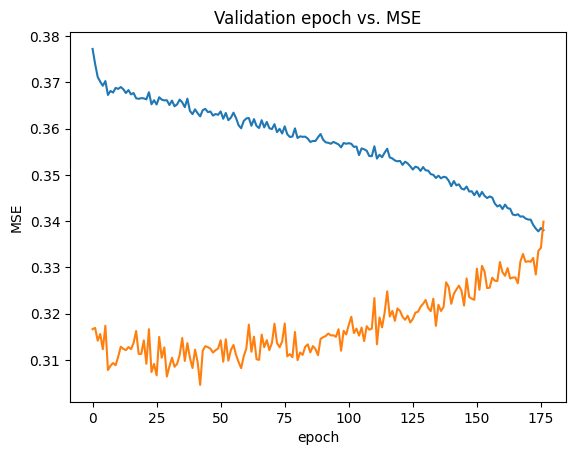

In [4]:
import matplotlib.pyplot as plt 

epochs = [i for i in range(len(train_metrics["mse"]))] 
plt.figure()
plt.title('1500 Training epoch vs. MSE') 
plt.plot(epochs, train_metrics['mse'])
plt.xlabel('epoch')
plt.ylabel('MSE')


plt.title('Validation epoch vs. MSE') 
plt.plot(epochs, vall_metrics['mse'])
plt.xlabel('epoch') 
plt.ylabel('MSE') 